# <a id='toc1_'></a>[COVID-19 Prediction](#toc0_)

Sam Celarek  
Data Science   
scelarek@gmail.com  

June 4th, 2023


**Table of contents**<a id='toc0_'></a>    
- [COVID-19 Prediction](#toc1_)    
- [1. Introduction](#toc2_)    
  - [1.1. Key Questions](#toc2_1_)    
- [2. Setup and Data Collection](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[1. Introduction](#toc0_)

In this project, we will perform a set of analyses on the relationship between different variables and the mosquito number, as well as the probability of finding West Nile Virus (WNV) at any particular time and location. 


## <a id='toc2_1_'></a>[1.1. Key Questions](#toc0_)

## <a id='toc2_1_'></a>[1.2. Data Sources and Methods](#toc0_)


# <a id='toc3_'></a>[2. Setup and Data Collection](#toc0_)

We will be utilizing the cleaned mosquito tracking data from the city of Chicago, Illinois, spanning from 2008 to 2019 provided [here](link_to_dataset). This section will include the necessary libraries and modules for the analysis, as well as the data preparation steps.


In [ ]:
from capstone_functions import *

In [ ]:
import covsirphy as cs

print(f"Covsirphy version: {cs.__version__}")


In [ ]:
# initialize styling params
np.random.seed(42)

# import warnings
# warnings.filterwarnings('ignore')
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot

cs.config.logger(level=2)

Country of Interest: United States of America

In [ ]:
country_ISO3 = "USA"
location_key = "US"



## CovSIRPhy Dataset Loading

The CovSIRPhy dataset is a collection of COVID-19 data from around the world, including the number of confirmed cases, recovered cases, and deaths. The data is collected from the following sources:


In [ ]:
eng = cs.DataEngineer()
eng.download(country=None, databases=["covid19dh", "owid", "wpp", 'japan'])

# Set Country of interest and Join Column for Other Dataframes

print("\n".join(eng.citations()))

In [ ]:
# Convert Date Column to Datetime, Resampling for only the dates in question, and Filling of Missing Values with Forward Fill and 0
eng.clean(kinds=['resample', 'fillna', 'convert_date'], date_range=('2020-01-03', '2022-09-15'))
eng.transform()

# Day to Day Differences
eng.diff(column="Confirmed", suffix="_Daily_Diff", freq="D")
eng.diff(column="Fatal", suffix="_Daily_Diff", freq="D")
eng.diff(column="Recovered", suffix="_Daily_Diff", freq="D")
eng.diff(column="Susceptible", suffix="_Daily_Diff", freq="D")
eng.diff(column="Tests", suffix="_Daily_Diff", freq="D")

# Addition
eng.add(columns=["Fatal", "Recovered"], new="Total_Removed")

# Division and Ratios
eng.div(numerator="Confirmed", denominator="Tests", new="Confirmed_per_Test")
eng.div(numerator="Fatal", denominator="Confirmed", new="Fatal_per_Confirmed")
eng.div(numerator="Recovered", denominator="Confirmed", new="Recovered_per_Confirmed")
eng.div(numerator="Fatal", denominator="Total_Removed", new="Fatal_to_Total_Removed")

eng.all().info()
eng.all().tail()

In [ ]:
# Create subset of data for the country of interest and the dates of interest
# Complement does two things here: forces always increasing cumulative values, estimates recovered cases using value of estimated recovery period

actual_df, status, _ = eng.subset(geo=country_ISO3, start_date='2020-01-03', end_date='2022-09-15', complement=True)
print(status)

actual_df.info()
display(actual_df.tail())


In [ ]:
# Create a SIRF Model from actual df
dyn_act = cs.Dynamics.from_data(model=cs.SIRFModel, data=actual_df, name=country_ISO3)

dyn_act.register().tail()


In [ ]:
# # Breakdown of the SIRF Model Parameters and points of change
# dyn_act.segment()

# Show summary
dyn_act.summary().tail(), dyn_act.summary().head()


# Data Dependencies? 

Are the parameters estimated from future values?

In [ ]:
# Calculate tau value and Disease Parameters from Actual SIRF Data
dyn_act.estimate()
print(f"Tau value [min]: {dyn_act.tau or 'un-set'}")

# Show summary
dyn_act.summary().head()


In [ ]:
# Interpolate Disease Parameters
track_df = dyn_act.track()
track_df.tail()


In [ ]:
# Assess Disease Parameter Data
track_df.info()

display(track_df.tail())

track_df.isna().sum().sum()


In [ ]:
# Assess USA Data
actual_df.info()

display(actual_df.tail())

actual_df.isna().sum().sum()


In [ ]:
# merge two datasets together on date
disease_df = pd.merge(actual_df, track_df, how='left', on='Date')


disease_df.info()

display(disease_df.head())

disease_df.isna().sum().sum()

## Cleaning

In [ ]:
disease_df
disease_df.columns = [i.lower().replace(' ', '_') for i in disease_df.columns]
disease_df = disease_df.rename_axis('date')
disease_df.info()
disease_df.head()

In [ ]:
disease_df.apply(lambda x: (x != x).sum())

In [ ]:
display(disease_df[disease_df.applymap(lambda x: (x != x)).fatal_per_confirmed][['confirmed', 'fatal', 'fatal_per_confirmed']].sum())
display(disease_df[disease_df.applymap(lambda x: (x != x)).fatal_to_total_removed][['fatal', 'total_removed', 'fatal_to_total_removed']].sum())
display(disease_df[disease_df.applymap(lambda x: (x != x)).confirmed_per_test][['confirmed', 'tests', 'confirmed_per_test']].sum())
display(disease_df[disease_df.applymap(lambda x: (x != x)).recovered_per_confirmed][['recovered', 'confirmed', 'recovered_per_confirmed']].sum())

disease_df = disease_df.applymap(lambda x: 0 if (x != x) else x)


In [ ]:
disease_df.apply(lambda x: (x != x).sum())

In [ ]:

disease_df.apply(lambda x: (x == np.inf).sum())

In [ ]:
display(disease_df[disease_df.applymap(lambda x: (x == np.inf)).confirmed_per_test][['confirmed', 'tests', 'confirmed_per_test']].head())


In [ ]:
disease_df = disease_df.applymap(lambda x: 1 if (x == np.inf) else x)


display(disease_df[disease_df.applymap(lambda x: (x == np.inf)).confirmed_per_test][['confirmed', 'tests', 'confirmed_per_test']].head())


In [ ]:
disease_df[disease_df.confirmed > disease_df.tests].sum()

## Google Datasets Loading and Cleaning

In [ ]:
folder_holder = "C://Users/Samsickle/Documents/Universal_Code_Bank/BrainStation_Capstone/Data/"


def clean_df(df, location_key):
    # Filter the dataframe based on location key and date.
    df = df.query('location_key == @location_key and date >= "2020-01-03"')
    
    # Rename the columns to lowercase and replace spaces with underscores.
    df.columns = [i.lower().replace(' ', '_') for i in df.columns]

    # Convert the 'date' column to datetime format and set it as index.
    df = df.set_index('date')
    df = df.drop(columns=['location_key'])
    df.index = pd.to_datetime(df.index)

    # Print the info and head of the DataFrame.
    df.info()
    display(df.head())

    return df


In [ ]:
# Load the hospitalizations data from the CSV file
hospitalizations_df = pd.read_csv(f'{folder_holder}hospitalizations.csv')

# # Load the mobility data from the CSV file
# mobility_df = pd.read_csv(f'{folder_holder}mobility.csv')

# # Load the weather data from the CSV file
# weather_df = pd.read_csv(f'{folder_holder}weather.csv')

# # Load the government response data from the CSV file
# gov_response_df = pd.read_csv(f'{folder_holder}oxford-government-response.csv')


In [ ]:
# Clean the hospitalizations data using the 'clean_df' function
hospitalizations_df = clean_df(hospitalizations_df, location_key)


In [ ]:
display(hospitalizations_df[hospitalizations_df.index < pd.to_datetime('2021-01-01')].isna().sum())

hospitalizations_df[hospitalizations_df.new_intensive_care_patients.isna()].reset_index().date.hist(bins=14)

In [ ]:
replace_nans_column = 'new_intensive_care_patients'

mask = (hospitalizations_df.index < pd.to_datetime('2021-01-01')) & (hospitalizations_df[replace_nans_column] != hospitalizations_df[replace_nans_column])
hospitalizations_df.loc[mask, replace_nans_column] = 0


In [ ]:
replace_nans_column = 'new_ventilator_patients'

mask = (hospitalizations_df.index < pd.to_datetime('2021-01-01')) & (hospitalizations_df[replace_nans_column] != hospitalizations_df[replace_nans_column])
hospitalizations_df.loc[mask, replace_nans_column] = 0


In [ ]:
hospitalizations_df[hospitalizations_df.new_intensive_care_patients.isna()].reset_index().date.hist(bins=14)

In [ ]:
hospitalizations_df.isna().sum().to_frame()
hospitalizations_df.corr().iloc[:,1].to_frame().style.background_gradient(cmap='coolwarm')

We are employing a strategy to impute missing values in our dataset, particularly for the variables 'ICU' and 'Ventilators'. This is achieved by leveraging the correlation between 'Hospitalizations' and these two variables, and by utilizing a simple linear regression model.

For the 'ICU' variable, the linear regression model is represented as:

$$ y = c + \beta \times x $$

where:

- $y$ represents the estimated ICU values.
- $x$ represents the 'Hospitalizations'. I subtracted the values of hospitalizations on the last day to set the value of x to 0.
- $\beta$ is calculated as the standard deviation ratio between 'Hospitalizations' and 'ICU', multiplied by the correlation strength between 'Hospitalizations' and 'ICU'. 
  - That is, $\beta = \frac{\sigma_{\text{Hospitalizations}}}{\sigma_{\text{ICU}}} \times r_{\text{Hospitalizations, ICU}}$.
- $c$ represents the last observed 'ICU' value.

For the 'Ventilators' variable, the linear regression model is represented as:

$$ y = c + \beta \times x $$

where:

- $y$ represents the estimated 'Ventilators' values.
- $x$ represents the 'Hospitalizations'. I subtracted the values of hospitalizations on the last day to set the value of x to 0.
- $\beta$ is calculated as the standard deviation ratio between 'Hospitalizations' and 'Ventilators', multiplied by the correlation strength between 'Hospitalizations' and 'Ventilators'. 
  - That is, $\beta = \frac{\sigma_{\text{Hospitalizations}}}{\sigma_{\text{Ventilators}}} \times r_{\text{Hospitalizations, Ventilators}}$.
- $c$ represents the last observed 'Ventilators' value.

These models provide a basis for filling in missing values based on the linear relationship between 'Hospitalizations' and the respective variables.

In [ ]:
# Find Beta0 
last_date = hospitalizations_df['cumulative_ventilator_patients'].idxmax()

vent_beta0 = hospitalizations_df.loc[last_date, 'cumulative_ventilator_patients']
intensive_beta0 = hospitalizations_df.loc[last_date, 'cumulative_intensive_care_patients']

# Find x
accum_hospitalized = hospitalizations_df.cumulative_hospitalized_patients
last_hospital_value = hospitalizations_df.loc[last_date, 'cumulative_hospitalized_patients']

vent_x = accum_hospitalized - last_hospital_value
intensive_x = accum_hospitalized - last_hospital_value

# Find Beta1
corr_vents = hospitalizations_df.corr().iloc[:,1].cumulative_ventilator_patients
corr_intensive = hospitalizations_df.corr().iloc[:,1].cumulative_intensive_care_patients

vent_beta1 = corr_vents * hospitalizations_df.cumulative_ventilator_patients.std() / accum_hospitalized.std()
intensive_beta1 = corr_intensive * hospitalizations_df.cumulative_intensive_care_patients.std() / accum_hospitalized.std()

# Linear Regression Equation
predicted_vents = vent_beta0 + (vent_beta1 * vent_x)

predicted_icu = intensive_beta0 + (intensive_beta1 * intensive_x)



In [ ]:
# Plotting before imputation
ax_before = hospitalizations_df.drop(columns='cumulative_hospitalized_patients').plot(title='Before Imputation', figsize=(10,5))
ax_before.set_xlabel("Date")
ax_before.set_ylabel("Count")
ax_before.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Imputing missing values
hospitalizations_df['cumulative_ventilator_patients'] = hospitalizations_df['cumulative_ventilator_patients'].fillna(predicted_vents) 
hospitalizations_df['cumulative_intensive_care_patients'] = hospitalizations_df['cumulative_intensive_care_patients'].fillna(predicted_icu)

# Plotting after imputation
ax_after = hospitalizations_df.drop(columns='cumulative_hospitalized_patients').plot(title='After Imputed ICU/Vent Data', figsize=(13,5))
ax_after.set_xlabel("Date")
ax_after.set_ylabel("Count")
ax_after.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout
plt.tight_layout()
plt.show()


In [ ]:
hospitalizations_df[hospitalizations_df.isna().new_intensive_care_patients]

hospitalizations_df['new_ventilator_patients'] = hospitalizations_df['cumulative_ventilator_patients'].fillna(predicted_vents) 
hospitalizations_df['new_intensive_care_patients'] = hospitalizations_df['new_intensive_care_patients'].fillna(predicted_icu)


array([<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>,
       <AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>,
       <AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>,
       <AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>,
       <AxesSubplot: xlabel='date'>], dtype=object)

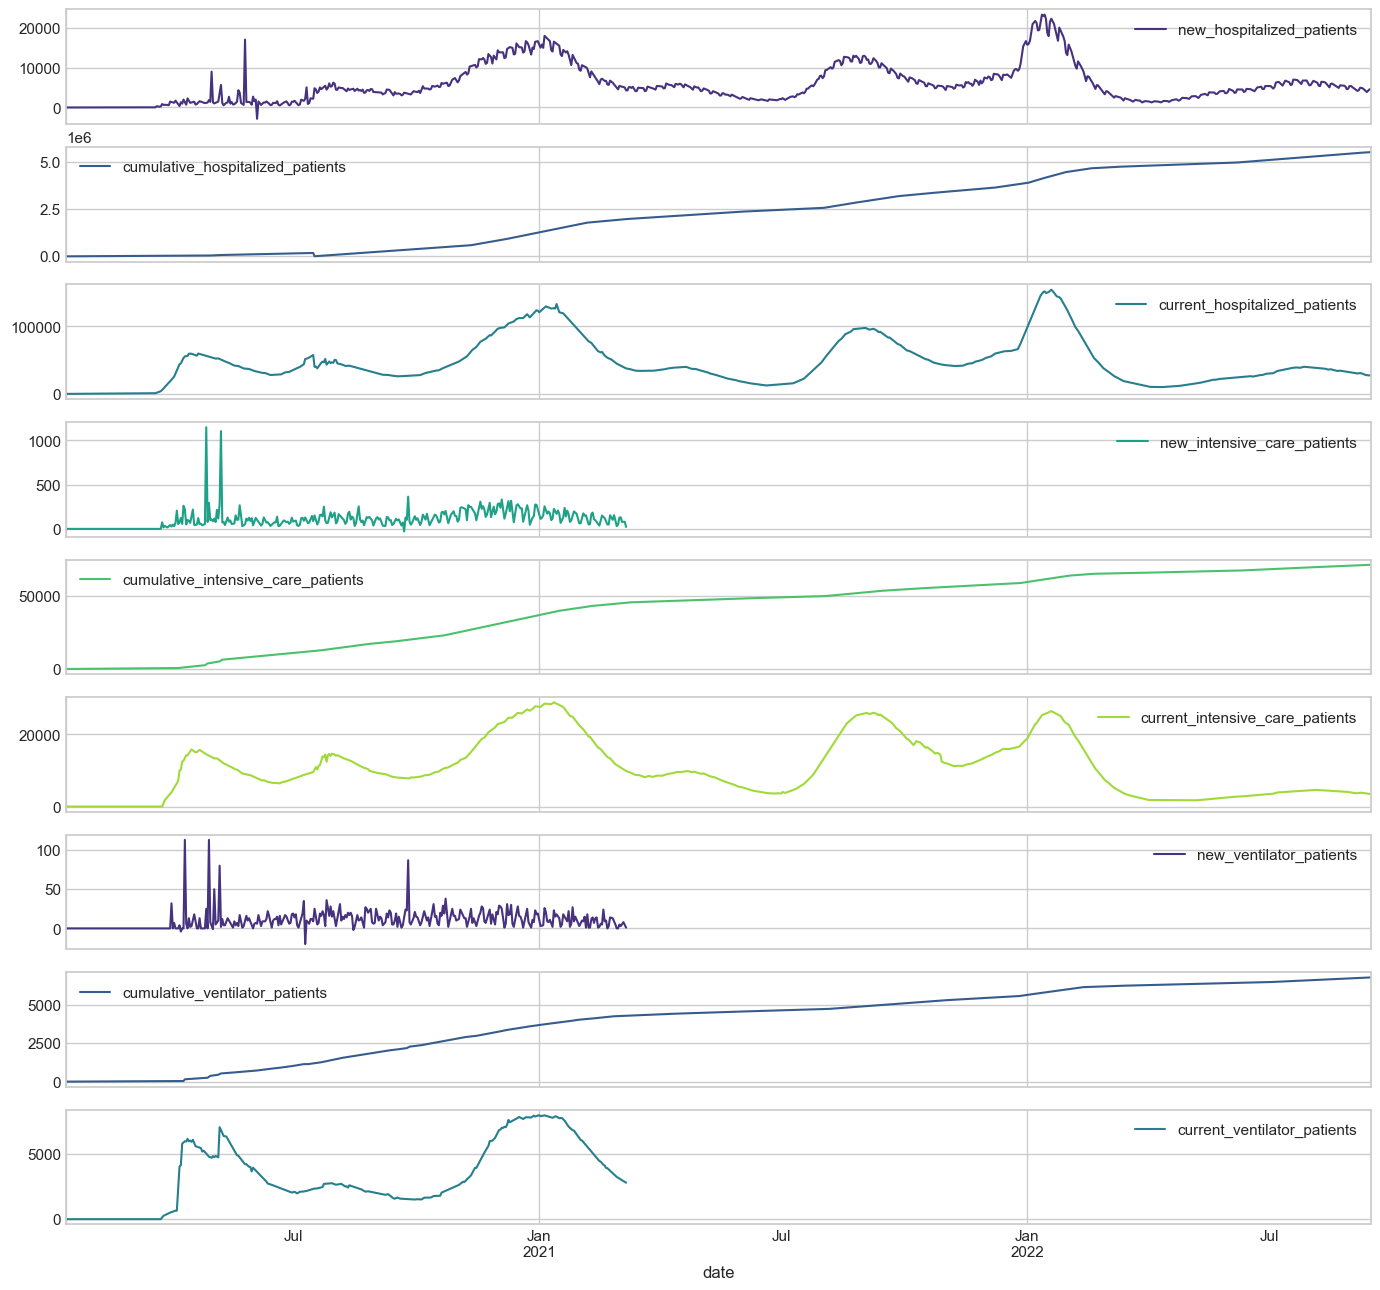

In [38]:
hospitalizations_df.plot(subplots=True, figsize=(15, 15))



In [ ]:

# Clean the mobility data using the 'clean_df' function
mobility_df = clean_df(mobility_df, location_key)



In [ ]:

# Clean the weather data using the 'clean_df' function and fill any NA/NaN values with 0
weather_df = clean_df(weather_df, location_key).fillna(0)


In [ ]:

# Clean the government response data using the 'clean_df' function
gov_response_df = clean_df(gov_response_df, location_key)


In [ ]:
# Calculate the number of common indices between the two dataframes.
len(disease_df.index) + len(gov_response_df.index) - len(disease_df.index.symmetric_difference(gov_response_df.index))


In [ ]:
# Identify columns common to 'disease_df' and 'gov_response_df'.
list_of_same_columns = disease_df.columns[disease_df.columns.isin(gov_response_df.columns)]

# Count duplicate rows when the common columns of the two dataframes are concatenated.
pd.concat([disease_df[list_of_same_columns], gov_response_df[list_of_same_columns]]).duplicated().sum()


In [ ]:
# Remove the common columns from 'gov_response_df'.
gov_response_df = gov_response_df.drop(columns = list_of_same_columns)


### Final Merging of Datasets

In [ ]:
# Create a list of dataframes to be merged
time_series_dfs = [disease_df, hospitalizations_df, mobility_df, gov_response_df, weather_df]

# Use functools.reduce to merge all dataframes in the list on 'date' column, with 'left' join method
master_df = reduce(lambda a, b: pd.merge(a, b, how='left', right_on='date', left_on='date'), time_series_dfs)

# Display summary and first few rows of the master dataframe
master_df.info()
master_df.head()


In [ ]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(master_df):
    master_df = master_df.drop(columns=['country_united_states', 'product_0', 'product_johnson&johnson,_moderna,_novavax,_pfizer/biontech', 'fiscal_measures', 'international_support', 'investment_in_vaccines', 'emergency_investment_in_healthcare'])
    return master_df

master_df = clean_data(master_df.copy())
master_df.head()

In [ ]:
# master_df.to_parquet('../Data/master_df.parquet', compression='snappy')
master_df = pd.read_parquet('../Data/master_df.parquet')

dfSummary(master_df, is_collapsible=True)

# ***DATA LEAKAGE ALERT***

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# Initialize the imputer
imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=100, random_state=42))

# Fit the imputer on the dataframe and transform
df_imputed = imputer.fit_transform(hospitalizations_df)

# Convert back to pandas dataframe and assign column names
df_imputed = pd.DataFrame(df_imputed, columns=master_df.columns)

df_imputed


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# Initialize the imputer
imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0))

# Fit the imputer on the dataframe and transform
df_imputed = imputer.fit_transform(master_df)

# Convert back to pandas dataframe and assign column names
df_imputed = pd.DataFrame(df_imputed, columns=master_df.columns)

df_imputed


In [ ]:
df_imputed.info()

### Extra Code

In [ ]:

# # Growth factor: (delta Number_n) / (delta Number_n)
# df = df.diff() / df.diff().shift(freq="D")

# # Rolling mean (window: 7 days)
# df = df.rolling(7).mean().dropna().loc[:covid_df["Date"].max(), :]
# numeric_columns_assessment(eng.all()).T

In [ ]:
# """
# Cell generated by Data Wrangler.
# """
# def clean_data(df):
#     # Filter rows based on column: 'location_key'
#     # df = df[df['location_key'].str.contains(r"^(US|CA|DE|GB|FR|JP|AU|BR|ZA|IN)$", na=False)]
#     df = df[df['location_key'].str.contains(r"^(US)$", na=False)] # only the us to start

#     # Change column type to datetime64[ns] for column: 'date'
#     try:
#         df = df.astype({'date': 'datetime64[ns]'})
#     except:
#         pass
#     # Change column type to category for column: 'location_key'
#     df = df.astype({'location_key': 'category'})
#     return df


# time_series_dfs = list(map(clean_data, timeland_df))

# # # Assume dfs is your list of dataframes
# time_series_dfs = reduce(lambda left,right: pd.merge(left,right,on=['location_key', 'date'], how='left'), time_series_dfs).copy()


In [ ]:
# time_series_dfs.to_parquet(f'{folder_holder}time_series_dfs.parquet.gzip', compression='gzip')

# time_series_dfs = pd.read_parquet(f'{folder_holder}time_series_dfs.parquet.gzip')

In [ ]:
# time_series_dfs_line_plot = time_series_dfs.dropna(subset='new_confirmed').copy()
# # sns.lineplot(data = time_series_dfs_line_plot, x = 'date', y = 'new_confirmed')

# time_series_dfs_line_plot.plot(x = 'date', y = 'new_confirmed', figsize = (15, 10))

# # add lines for each column
# fig = px.line(time_series_dfs_line_plot, x=air_traffic.index, y=air_traffic.columns,)

# # axis labels and title
# fig.update_layout(
#     yaxis_title="Passenger-miles (billions)", 
#     legend_title="", 
#     title="Daily air travel from 1979 to 2002"
# )

# # activate slider
# fig.update_xaxes(rangeslider_visible=True)

# fig.show()

In [ ]:
# folder_holder = "C://Users/Samsickle/Documents/BrainStation_Capstone/Data/"
# # C:\Users\Samsickle\Documents\BrainStation_Capstone\Data

# # # # time series data
# # hospitalizations_df = pd.read_csv(f'{folder_holder}hospitalizations.csv') # 2
# # mobility_df = pd.read_csv(f'{folder_holder}mobility.csv') # 4
# # gov_response_df = pd.read_csv(f'{folder_holder}oxford-government-response.csv') # 5
# # weather_df = pd.read_csv(f'{folder_holder}weather.csv') # 6

# epid_df = pd.read_csv(f'{folder_holder}epidemiology.csv') # 1
# # vac_df = pd.read_csv(f'{folder_holder}vaccinations.csv') # 3


In [ ]:
# epid_df.sample(5)

In [ ]:
# Performs a Fillna with FFill on the data set or a fillna with a 0 if there is no previous value
# Retrieves only the dates between '2020-01-01' and '2022-09-15'

# eng.clean(kinds=['resample', 'fillna'], date_range=('2020-01-03', '2022-09-15'))
# eng.all().query('ISO3 == @country_ISO3').isna().sum().sum()

# creates an engine with only USA data and with the desire date
# complement does three things, forces always increasing cumulate values, estimates recovered cases using value of estimated recovery period

# eng.subset(geo=country_ISO3, start_date='2020-01-03', end_date='2022-09-15', complement=True)
# eng.all().ISO3.unique(), eng.all().Date.min(), eng.all().Date.max()
# Uses the SIR model to estimate the number of infected and susceptible people

# main_variables = ['Infected', 'Susceptible']
# eng.transform()
# eng.all().query('ISO3 == @country_ISO3').info()
# eng.all().query('ISO3 == @country_ISO3')[main_variables].describe().T
# estimates the length of recovery and the length of the incubation period


# eng.clean()
# eng.transform()


# actual_df, status, _ = eng.subset(geo=country_ISO3, start_date='2020-01-03', end_date='2022-09-15', complement=True)
# print(status)
# actual_df.tail()



# with_df, status, status_dict = eng.subset(geo=@country_ISO3, start_date='2020-01-01', end_date='2022-09-15', complement=True)
# print(f"{status}\n")
# print(status_dict)
# with_df.info()
# with_df.head()


# """
# Cell generated by Data Wrangler.
# """
# def clean_data(with_df):
#     # Replace all instances of 0 with 0 in column: 'Positive_rate'
#     with_df.loc[with_df['Positive_rate'] != with_df['Positive_rate'], 'Positive_rate'] = 0
#     with_df.loc[with_df['Positive_rate'] == np.inf, 'Positive_rate'] = 0
#     return with_df

# with_df_clean = clean_data(with_df.copy())
# with_df_clean.head()
# cs.line_plot(with_df[["Confirmed", "Fatal", "Recovered"]], title="USA: records WITH complement")
# with_df.info()

# snr_act = cs.ODEScenario.auto_build(geo=country_ISO3, model=cs.SIRFModel, complement=True)

# snr_act.simulate(name="Baseline");
# dyn_act = snr_act.to_dynamics(name="Baseline")
# # Show summary
# display(dyn_act.summary())
# # Simulation
# dyn_act_df = dyn_act.simulate(model_specific=False)
# cs.line_plot(
#     dyn_act_df.drop("Susceptible", axis=1), "USA: Simulated data (Baseline scenario)")

Data Wireframe:

1. Date and Location:
    - 'date' - the day of the observations
    - 'location_key' - the country of the observations. I choose ten countries of interest in different regions

United States (US)  
Canada (CA)  
Germany (DE)  
United Kingdom (GB)  
France (FR)  
Japan (JP)  
Australia (AU)  
Brazil (BR)  
South Africa (ZA)  
India (IN)  
These countries are often used as indicators for their respective regions due to their significant economic influence, political stability, and comprehensive data collection practices.

2. COVID-19 Statistics:
    - 'new_confirmed' (New Positive Cases) - the number of new confirmed cases of COVID-19, this includes some negative numbers to account for data corrections in the previous days, however because these numbers are aggregated accross a whole country, the negative numbers are often very small and remain positive
    - 'new_deceased' (New Deaths) - the number of new deaths due to COVID-19 also shares the negative number problem
    - 'new_hospitalized_patients' (New Hospitalizations) 

3. Mobility Data:
    - 'mobility_retail_and_recreation'
    - 'mobility_grocery_and_pharmacy'
    - 'mobility_parks'
    - 'mobility_transit_stations'
    - 'mobility_workplaces'
    - 'mobility_residential'



4. Vaccination Data:
    - 'new_persons_vaccinated'
    - 'cumulative_persons_vaccinated'
    - 'new_persons_fully_vaccinated'
    - 'cumulative_persons_fully_vaccinated'
    - 'new_vaccine_doses_administered'
    - 'cumulative_vaccine_doses_administered'

5. Policy Measures:
    - 'school_closing'
    - 'workplace_closing'
    - 'cancel_public_events'
    - 'restrictions_on_gatherings'
    - 'public_transport_closing'
    - 'stay_at_home_requirements'
    - 'restrictions_on_internal_movement'
    - 'international_travel_controls'
    - 'income_support'
    - 'debt_relief'
    - 'fiscal_measures'
    - 'international_support'
    - 'public_information_campaigns'
    - 'testing_policy'
    - 'contact_tracing'
    - 'emergency_investment_in_healthcare'
    - 'investment_in_vaccines'
    - 'facial_coverings'
    - 'vaccination_policy'
    - 'stringency_index'

6. Weather Data:
    - 'average_temperature_celsius'
    - 'minimum_temperature_celsius'
    - 'maximum_temperature_celsius'
    - 'rainfall_mm'
    - 'snowfall_mm'
    - 'dew_point'
    - 'relative_humidity'


In [ ]:
# # location dfs
# geography_df = pd.read_csv(f'{folder_holder}geography.csv') #1
# health_df = pd.read_csv(f'{folder_holder}health.csv') #2
# demographics_df = pd.read_csv(f'{folder_holder}demographics.csv') #3
# economics_df = pd.read_csv(f'{folder_holder}economy.csv') #4


# locationland_df = [geography_df, health_df, demographics_df, economics_df]

In [ ]:
# location_df = list(map(clean_data, locationland_df))

# # Assume dfs is your list of dataframes
# location_df = reduce(lambda left,right: pd.merge(left,right,on='location_key', how='left'), location_df).copy()

# location_df.head()


In [ ]:

# location_df.to_pickle('../Data/location_df.pkl')
# location_df = pd.read_pickle('../Data/location_df.pkl')

# location_df.sample(3)

This dataframe provides a comprehensive snapshot of COVID-19 data, mobility metrics, government restrictions, and weather conditions for specific locations on specific dates. Here's a brief overview of the columns:

1. `Entry ID`: A unique identifier for each row in the dataframe.
2. `Date`: The date for the day on which the data was recorded.
3. `Location Key`: A code representing the location (10 different countries in total) for which the data is reported.

4. `New Confirmed`: The number of new confirmed COVID-19 cases on the given date.
5. `New Deceased`: The number of new COVID-19 related deaths on the given date.
6. `New Recovered`: The number of new recoveries from COVID-19 on the given date.
7. `New Tested`: The number of new COVID-19 tests conducted on the given date.

8. `New Hospitalizations`: The number of new hospitalizations due to COVID-19 on the given date.
9. `Current Hospitalizations`: The total number of current hospitalizations due to COVID-19 on the given date.

10. `New Fully Vaccinated (29+ other Vaccination Columns)`: The number of new fully vaccinated individuals on the given date. There are 29 other columns related to vaccination data here too.

11. `Retail and Recreation Mobility (5+ other Mobility Metrics)`: A measure of mobility in retail and recreation spaces, along with 5 other columns related to different aspects of mobility.

12. `School Closing (19+ other Government Restrictions)`: A measure indicating whether schools were closed on the given date, along with 19 other columns related to different government restrictions.

13. `Average Temp (6+ Other Weather Columns)`: The average temperature on the given date, along with 6 other columns related to different weather conditions.

In total there are 9880 and 82 rows for 6.3mbs of data. The main way I could increase or decrease the size of the dataset would be to include more countries, regions, or counties in the analysis. For now this is my starter df.
